# Create a pass manager for dynamical decoupling

This page demonstrates how to use the [`PadDynamicalDecoupling`](/api/qiskit/qiskit.transpiler.passes.PadDynamicalDecoupling) pass to add an error suppression technique called _dynamical decoupling_ to the circuit.

Dynamical decoupling works by adding pulse sequences (known as _dynamical decoupling sequences_) to idle qubits to flip them around the Bloch sphere, which cancels the effect of noise channels, thereby suppressing decoherence. These pulse sequences are similar to refocusing pulses used in nuclear magnetic resonance. For a full description, see [A Quantum Engineer's Guide to Superconducting Qubits](https://arxiv.org/abs/1904.06560).

Because the `PadDynamicalDecoupling` pass only operates on scheduled circuits and involves gates that are not necessarily basis gates of our target, you will need the [`ALAPScheduleAnalysis`](/api/qiskit/qiskit.transpiler.passes.ALAPScheduleAnalysis) and [`BasisTranslator`](/api/qiskit/qiskit.transpiler.passes.BasisTranslator) passes as well.

This example uses `ibm_brisbane`, which was initialized previously. Get the `target` information from the `backend` and save the operation names as `basis_gates` because the `target` will need to be modified to add timing information for the gates used in dynamical decoupling.

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

target = backend.target
basis_gates = list(target.operation_names)

Create an `EfficientSU2` circuit as an example. First, transpile the circuit to the backend because dynamical decoupling pulses need to be added after the circuit has been transpiled and scheduled. Dynamical decoupling often works best when there is a lot of idle time in the quantum circuits - that is, there are qubits that are not being used while others are active. This is the case in this circuit because the two-qubit `ecr` gates are applied sequentially in this ansatz.

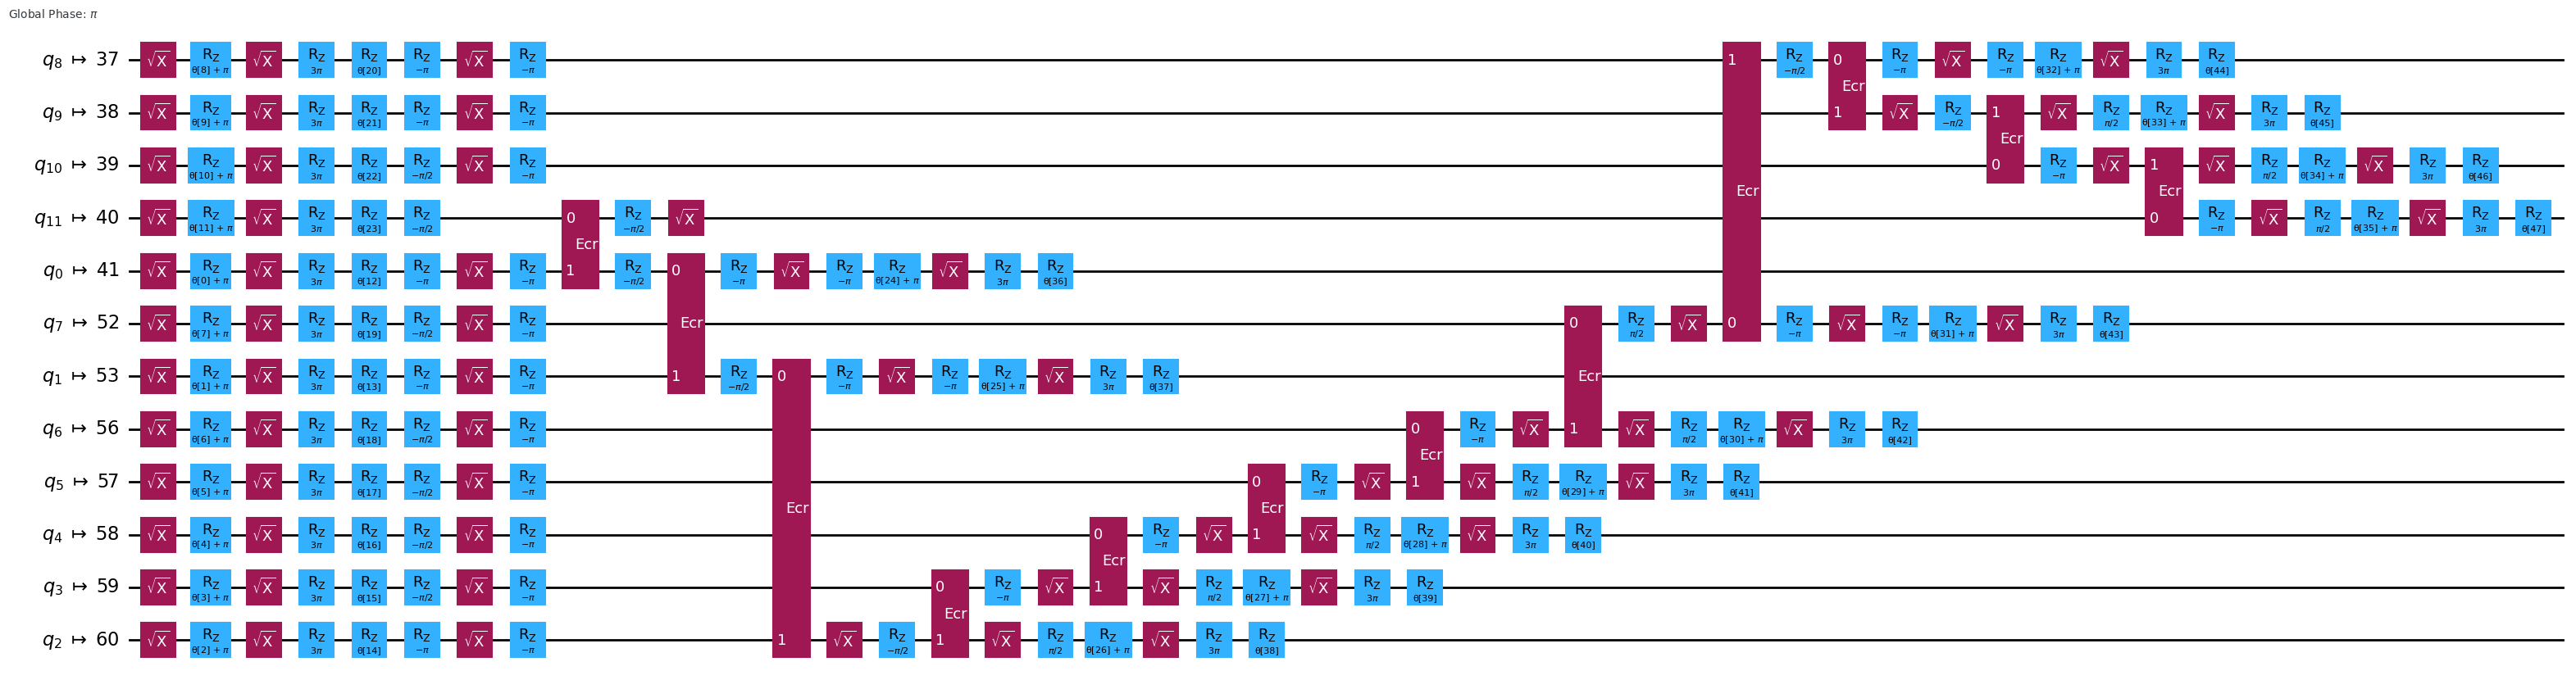

In [2]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import EfficientSU2

qc = EfficientSU2(12, entanglement="circular", reps=1)
pm = generate_preset_pass_manager(1, target=target, seed_transpiler=12345)
qc_t = pm.run(qc)
qc_t.draw("mpl", fold=-1, idle_wires=False)

A dynamical decoupling sequence is a series of gates that compose to the identity and are spaced regularly in time. For example, start by creating a simple sequence called XY4 consisting of four gates.

In [3]:
from qiskit.circuit.library import XGate, YGate

X = XGate()
Y = YGate()

dd_sequence = [X, Y, X, Y]

Because of the regular timing of dynamical decoupling sequences, information about the `YGate` must be added to the `target` because it is *not* a basis gate, whereas the `XGate` is. We know *a priori* that the `YGate` has the same duration and error as the `XGate`, however, so we can just retrieve those properties from the `target` and add them back for the `YGate`s. This is also why the `basis_gates` were saved separately, since we are adding the `YGate` instruction to the `target` although it is not an actual basis gate of `ibm_brisbane`.

In [4]:
from qiskit.transpiler import InstructionProperties

y_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )

target.add_instruction(YGate(), y_gate_properties)

Ansatz circuits such as `EfficientSU2` are parameterized, so they must have value bound to them before being sent to the backend. Here, assign random parameters.

In [5]:
import numpy as np

rng = np.random.default_rng(1234)
qc_t.assign_parameters(rng.uniform(-np.pi, np.pi, qc_t.num_parameters), inplace=True)

Next, execute the custom passes. Instantiate the `PassManager` with `ALAPScheduleAnalysis` and `PadDynamicalDecoupling`.  Run `ALAPScheduleAnalysis` first to add timing information about the quantum circuit before the regularly-spaced dynamical decoupling sequences can be added. These passes are run on the circuit with `.run()`.

In [6]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

dd_pm = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
    ]
)
qc_dd = dd_pm.run(qc_t)

Use the visualization tool [`timeline_drawer`](/api/qiskit/qiskit.visualization.timeline_drawer) to see the circuit's timing and confirm that a regularly-spaced sequence of `XGate`s and `YGate`s appear in the circuit.

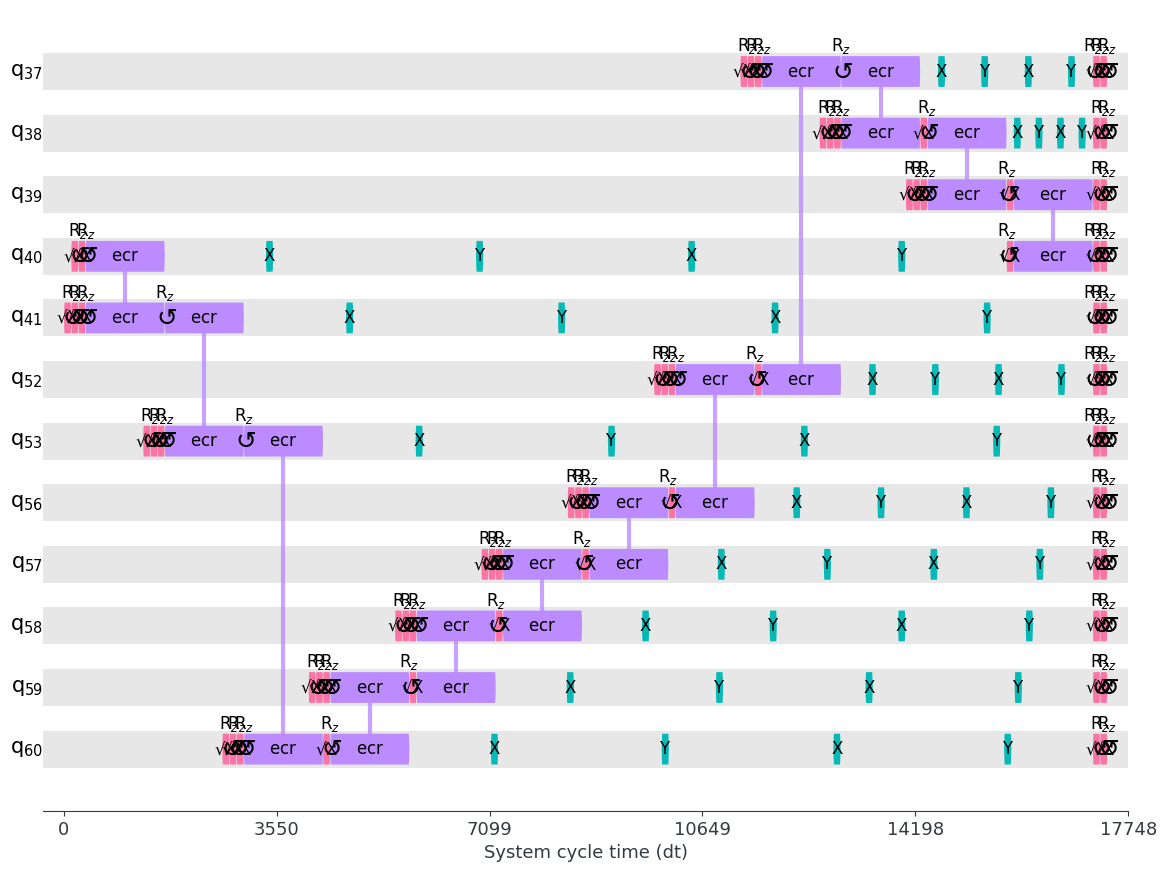

In [7]:
from qiskit.visualization import timeline_drawer

timeline_drawer(qc_dd, show_idle=False)

Lastly, because the `YGate` is not an actual basis gate of our backend, manually apply the `BasisTranslator` pass (this is a default pass, but it is executed before scheduling, so it needs to be applied again). The session equivalence library is a library of circuit equivalences that allows the transpiler to decompose circuits into basis gates, as also specified as an argument.

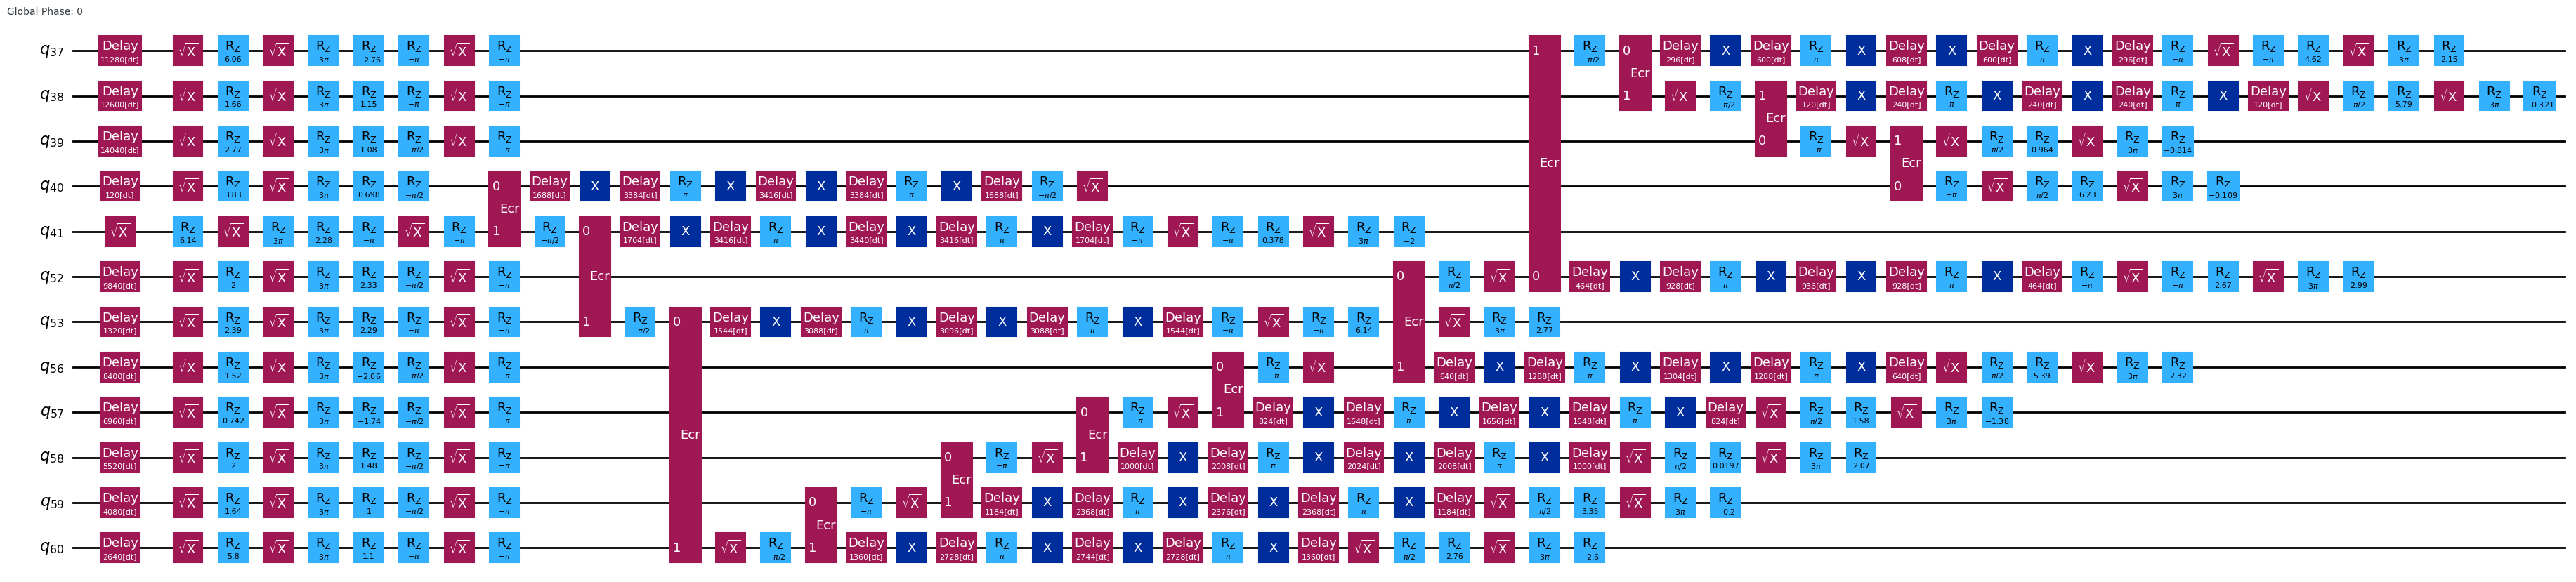

In [8]:
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel
from qiskit.transpiler.passes import BasisTranslator

qc_dd = BasisTranslator(sel, basis_gates)(qc_dd)
qc_dd.draw("mpl", fold=-1, idle_wires=False)

Now, `YGate`s are absent from our circuit, and there is explicit timing information in the form of `Delay` gates. This transpiled circuit with dynamical decoupling is not ready to be sent to the backend. When doing so, remember to set the `skip_transpilation=True` option (See [Advanced runtime compilation options](/run/configure-runtime-compilation#advanced-runtime-compilation-options)).

## Next steps

<Admonition type="tip" title="Recommendations">
    - To learn how to use the `transpile` function, start with the [Transpilation default settings and configuration options](defaults-and-configuration-options) topic.
    - Try the [Submit transpiled circuits](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits) tutorial.
    - See the [Transpile API documentation.](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler)
</Admonition>